# Общее описание проекта

<b>Проект</b>: предсказание закрытия стартапа. 

<b>Описание проекта:</b> 
Соревнование для студентов курса Data Science, на котором предстоит поработать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. 

<b>Задачи:</b> 

1. Построить модель, которая сможет предсказать статус стартапа.
2. С помощью построенной модели сделать прогноз состояния стартапов на тестовой выборке.


<b>Ход исследования:</b>

	* Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов.    
	* Предобработка данных: обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
	* Исследовательский анализ данных.
	* Подготовка данных.
	* Обучение модели.
    * Выводы.

<b>Общий вывод:</b> резюмирование полученных результатов, формулирование ключевых выводов и рекомендаций.

# Загрузка данных

In [1]:
# загружаем требуемые модули
#!pip install phik -q
#!pip install shap -q
#!pip install matplotlib==3.5.0 -q
#!pip install -U scikit-learn -q
#!pip install catboost -q

In [2]:
# загружаем требуемые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
pd.set_option('display.max_columns', None)

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
#import shap
import os

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42

Загрузим файлы с данными:

Тренировочная выборка:
kaggle_startups_train_28062024.csv

Тестовая выборка:
kaggle_startups_train_28062024.csv

In [3]:
train_df = pd.read_csv('datasets/kaggle_startups_train_28062024.csv', sep=',', decimal='.', \
                       parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

In [4]:
train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [5]:
test_features = pd.read_csv('datasets/kaggle_startups_test_28062024.csv', sep=',', decimal='.',\
                            parse_dates=['first_funding_at', 'last_funding_at'])

In [6]:
test_features.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


# Предобработка данных

Изучим данные и сделаем выводы. Выполним необходимую предобработку. 

### Проверим данные на наличие дубликатов

In [7]:
train_df.duplicated().sum()

0

In [8]:
test_features.duplicated().sum()

0

### Проверим типы данных

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [10]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


## Устраним неявные дубликаты категориальных признаков

In [11]:
cat_columns = [
    'category_list', # займемся отдельно
    'country_code',  # вроде бы нет дубликатов
    'state_code',    # пока не понимаю, есть ли неявные дубликаты 
    'region',        # возможно, есть неявные дубликаты (Zürich/Zurich)
    'city'           # возможно, есть неявные дубликаты (Zürich/Zurich)
]
# Train data
for i in cat_columns:
    print(train_df[i].unique())
print(train_df['status'].unique())

# Test data
for i in cat_columns:
    print(test_features[i].unique())

['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']
['CHE' 'USA' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS' 'TWN'
 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD' 'ARG'
 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA' 'GRC'
 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA' 'JOR'
 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX' 'SVN'
 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA' 'TTO'
 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT' 'PSE'
 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY' 'BMU'
 'TAN' 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA' 'LAO' 'TUN'
 'HND' 'ZWE' 'BAH' 'MDA' 'MAF' 'BHR' 'AZE' 'MAR' 'KWT' 'IRN' 'GGY' 'KNA'
 'PRI' 'OMN' 'KAZ' 'JAM' 'NPL' 'ARM' 'TGO' 'RWA' 'BRN

Вывод: имеется много неявных дубликатов в поле category_list. Выполним укрупнение с помощью анализа и соответствующих функций.

### Категория: 1-ый этап укрупнения - по ключевому слову

Посмотрим, какие из категорий встречаются чаще всего.

In [12]:
train_df['category_list'].value_counts()

category_list
Software                                                                                  3207
Biotechnology                                                                             2905
E-Commerce                                                                                1064
Mobile                                                                                     920
Clean Technology                                                                           892
                                                                                          ... 
iPad|Reviews and Recommendations|Social Television|Software|Television|Video on Demand       1
Graphics|Software|Startups                                                                   1
Curated Web|File Sharing|Graphics|PaaS                                                       1
Cloud Computing|Cloud Data Services|Databases|IaaS|Services|Software|Virtualization          1
Online Rental|Parking|Price Comparis

In [13]:
test_features['category_list'].value_counts()

category_list
Software                                                                                                  775
Biotechnology                                                                                             693
E-Commerce                                                                                                263
Mobile                                                                                                    255
Clean Technology                                                                                          234
                                                                                                         ... 
Advertising|Video|Video Streaming                                                                           1
Business Services|Customer Service|Risk Management                                                          1
Financial Services|Predictive Analytics                                                                   

Составим перечень наиболее часто встречающихся категорий

In [14]:
cat_candidates = [
    'Software',
    'E-Commerce',
    'Mobile',
    'Biotechnology',
    'Clean Technology',
    'Curated Web',
    'Health',
    'Manufacturing',
    'Advertising',
    'Education',
    'Semiconductors',
    'Finance',
    'Real Estate',
    'Consulting',
    'Social Media',
    'Security',
    'Hospitality',
    'Web Hosting',
    'Analytics',
    'Fashion',
    'Technology',
    'Medical',
    'Travel',
    'Internet',
    'News',
    'Sports',
    'Music',
    'Apps',
    'Messaging',
    'Pharmaceuticals',
    'Financial Services',
    'Public Relations',
    'Automotive',
    'Search',
    'Transportation',
    'Photography',
    'Services',
    'Design',
    'Telecommunications',
    'Nonprofits',
    'Entertainment',
    'Food Processing',
    'Legal',
    'Retail',
    'Networking',
    'Energy',
    'Electronics',
    'Consumer Goods',
    'Marketplaces',
    'Game'
]

Подготовим функцию для отнесения записи к новой, более крупной, категории с помощью подготовленной функции и перечня ключевых категорий:

In [15]:
def categorize_cat(row):
    cat_list = row['category_list']
    for i in cat_candidates:
        if pd.notnull(cat_list) and i in cat_list:
            return i
    return 'not defined'

In [16]:
train_df['category'] = train_df.apply(categorize_cat, axis=1)

In [17]:
train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,not defined
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,Health
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing


In [18]:
train_df['category'].nunique()

51

Попробуем уменьшить кол-во категорий

### Категория: 2-ой этап укрупнения

In [19]:
def categorize_cat_big(row):
    category = row['category']
    if category in ('Game'):
        return 'Entertainment'
    if category in ('Medical'):
        return 'Health'
    if category in ('Web Hosting'):
        return 'Internet'
    if category in ('Consumer Goods', 'Marketplaces'):
        return 'Retail'
    if category in ('Apps'):
        return 'Software'
    if category in ('Automotive'):
        return 'Transportation'
    return category

In [20]:
train_df['cat_big'] = train_df.apply(categorize_cat_big, axis=1)

In [21]:
train_df['cat_big'].nunique()

44

Выполним аналогичные операции по укрупнению категорий на тестовой выборке

In [22]:
test_features['category'] = test_features.apply(categorize_cat, axis=1)
test_features['cat_big'] = test_features.apply(categorize_cat_big, axis=1)
test_features['cat_big'].nunique()

44

In [23]:
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  category           13125 non-null  object        
 12  cat_big            13125 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(8)
memory 

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,category,cat_big
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Clean Technology,Clean Technology
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,Hospitality
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,Finance
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software,Software
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,Software


### Посмотрим на другие поля

#### country_code

In [24]:
train_df['country_code'].nunique()

134

In [25]:
train_df['country_code'].value_counts()

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

#### state_code

In [26]:
train_df['state_code'].nunique()

300

In [27]:
train_df['state_code'].value_counts() #.sort_index()

state_code
CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
      ...  
PE        1
Y1        1
O2        1
V3        1
U6        1
Name: count, Length: 300, dtype: int64

In [28]:
test_features['state_code'].value_counts()

state_code
CA    2552
NY     789
MA     487
TX     410
H9     382
      ... 
WE       1
71       1
F9       1
D2       1
W3       1
Name: count, Length: 235, dtype: int64

#### region

In [29]:
train_df['region'].nunique()

1036

In [30]:
train_df['region'].value_counts()

region
SF Bay Area            6970
New York City          2776
Boston                 1890
London                 1840
Los Angeles            1513
                       ... 
Helena                    1
Castelfranco Veneto       1
Taunton                   1
Vevey                     1
Doncaster                 1
Name: count, Length: 1036, dtype: int64

#### city

In [31]:
train_df['city'].nunique()

4477

In [32]:
train_df['city'].value_counts()

city
San Francisco    2824
New York         2486
London           1514
Austin            609
Palo Alto         607
                 ... 
Beppu               1
Idukki              1
Reutlingen          1
Sulphur             1
Centreville         1
Name: count, Length: 4477, dtype: int64

## Заполним пропуски

Для поле closed_at в тренировочной выборке: заменим пустые значения на дату получения статистики для того, чтобы далее вычислить корректный lifetime (который добавляется в разделе "Добавим новые признаки")

In [33]:
train_df['closed_at'].fillna(value=pd.to_datetime('1/1/2018'), inplace=True) 

funding_total_usd

In [34]:
train_df['funding_total_usd'] = train_df['funding_total_usd'].fillna(0).astype(np.int64)

In [35]:
test_features['funding_total_usd'] = test_features['funding_total_usd'].fillna(0).astype(np.int64)

state_code

In [36]:
train_df['state_code'].fillna('XX', inplace=True)
test_features['state_code'].fillna('XX', inplace=True)

city

In [37]:
train_df['city'].fillna('XX', inplace=True)
test_features['city'].fillna('XX', inplace=True)

country_code

In [38]:
train_df['country_code'].fillna('XX', inplace=True)
test_features['country_code'].fillna('XX', inplace=True)

region

In [39]:
train_df['region'].fillna('XX', inplace=True)
test_features['region'].fillna('XX', inplace=True)

## Проверим данные на наличие новых дубликатов

In [40]:
train_df.duplicated().sum()

0

In [41]:
test_features.duplicated().sum()

0

Вывод: имена признаков и их типы - корректные, дубликатов нет, но имеются пропуски, которые мы заполнили уместными, на наш взгляд, значениями: funding_total_usd - 0, а state_code, city, country_code и region - значением 'XX'.

# Исследовательский анализ данных

Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

## Добавим новые признаки

lifetime для train data

In [42]:
train_df['lifetime'] = train_df['closed_at'] - train_df['founded_at']

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   name               52515 non-null  object         
 1   category_list      50051 non-null  object         
 2   funding_total_usd  52516 non-null  int64          
 3   status             52516 non-null  object         
 4   country_code       52516 non-null  object         
 5   state_code         52516 non-null  object         
 6   region             52516 non-null  object         
 7   city               52516 non-null  object         
 8   funding_rounds     52516 non-null  int64          
 9   founded_at         52516 non-null  datetime64[ns] 
 10  first_funding_at   52516 non-null  datetime64[ns] 
 11  last_funding_at    52516 non-null  datetime64[ns] 
 12  closed_at          52516 non-null  datetime64[ns] 
 13  category           52516 non-null  object     

In [44]:
train_df['lifetime'] = train_df['lifetime'].dt.days

## Количественные признаки

In [45]:
train_df.describe().T

,count,mean,min,25%,50%,75%,max,std
funding_total_usd,52516.0,14748853.893632,0.0,40000.0,1000000.0,6788929.0,30079503000.0,168378343.179467
funding_rounds,52516.0,1.74067,1.0,1.0,1.0,2.0,19.0,1.374522
founded_at,52516,2008-11-04 09:44:16.196206848,1970-02-05 00:00:00,2006-10-01 00:00:00,2010-10-01 00:00:00,2013-01-01 00:00:00,2016-04-02 00:00:00,NaN
first_funding_at,52516,2011-07-17 04:45:33.247010304,1977-05-15 00:00:00,2009-10-12 00:00:00,2012-07-23 00:00:00,2014-04-01 00:00:00,2015-12-05 00:00:00,NaN
last_funding_at,52516,2012-06-27 16:29:42.313961472,1977-05-15 00:00:00,2011-02-01 00:00:00,2013-08-30 00:00:00,2014-11-17 00:00:00,2015-12-07 00:00:00,NaN
closed_at,52516,2017-06-11 05:36:46.504684032,1983-10-06 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,NaN
lifetime,52516.0,3140.828129,19.0,1739.0,2557.0,4018.0,17378.0,2147.82107


In [46]:
test_features.describe().T

,count,mean,min,25%,50%,75%,max,std
funding_total_usd,13125.0,13298543.698057,0.0,40000.0,950000.0,6513865.0,4715000000.0,82886614.314212
funding_rounds,13125.0,1.714438,1.0,1.0,1.0,2.0,15.0,1.3188
first_funding_at,13125,2011-07-23 20:54:08.640000,1973-04-15 00:00:00,2009-11-16 00:00:00,2012-08-01 00:00:00,2014-04-01 00:00:00,2015-12-03 00:00:00,NaN
last_funding_at,13125,2012-06-16 05:03:41.348571392,1973-04-15 00:00:00,2011-01-10 00:00:00,2013-08-21 00:00:00,2014-11-11 00:00:00,2015-12-12 00:00:00,NaN
lifetime,13125.0,3097.609524,52.0,1726.0,2526.0,3866.0,17167.0,2128.356554


In [47]:
train_df['first_funding_at'] = train_df['first_funding_at'].astype("int64")
train_df['last_funding_at'] = train_df['last_funding_at'].astype("int64")

In [48]:
num_columns = [
    'funding_total_usd',
    'funding_rounds',
    'lifetime',
    'first_funding_at',
    'last_funding_at'
]

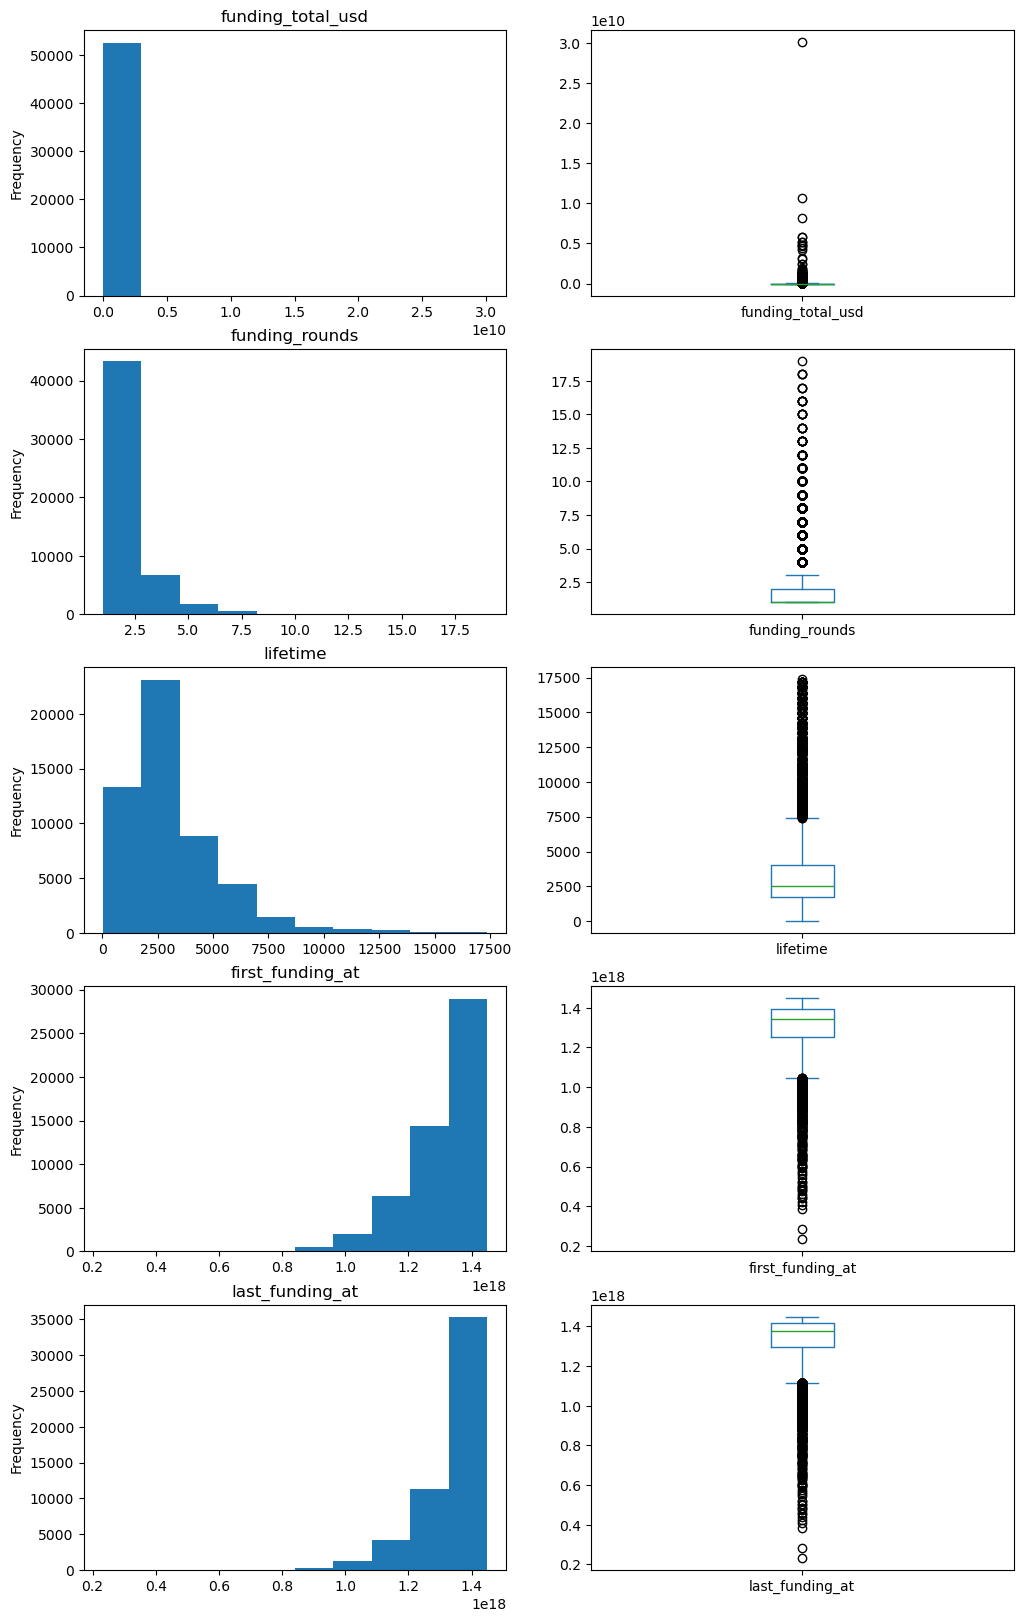

In [49]:
# train_df

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
ax = ax.flatten()
j = 0
for i in num_columns:
    train_df[i].plot(kind='hist', ax=ax[j], rot=0)
    ax[j].set_title(i);
    train_df[i].plot(kind='box', ax=ax[j+1], rot=0)
    j = j + 2

Много значений за пределами "усов ящика" для всех указанных полей.

In [50]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  13125 non-null  int64         
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  category           13125 non-null  object        
 12  cat_big            13125 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(8)
memory usage: 1.3+ 

In [51]:
test_features['first_funding_at'] = test_features['first_funding_at'].astype("int64")
test_features['last_funding_at'] = test_features['last_funding_at'].astype("int64")

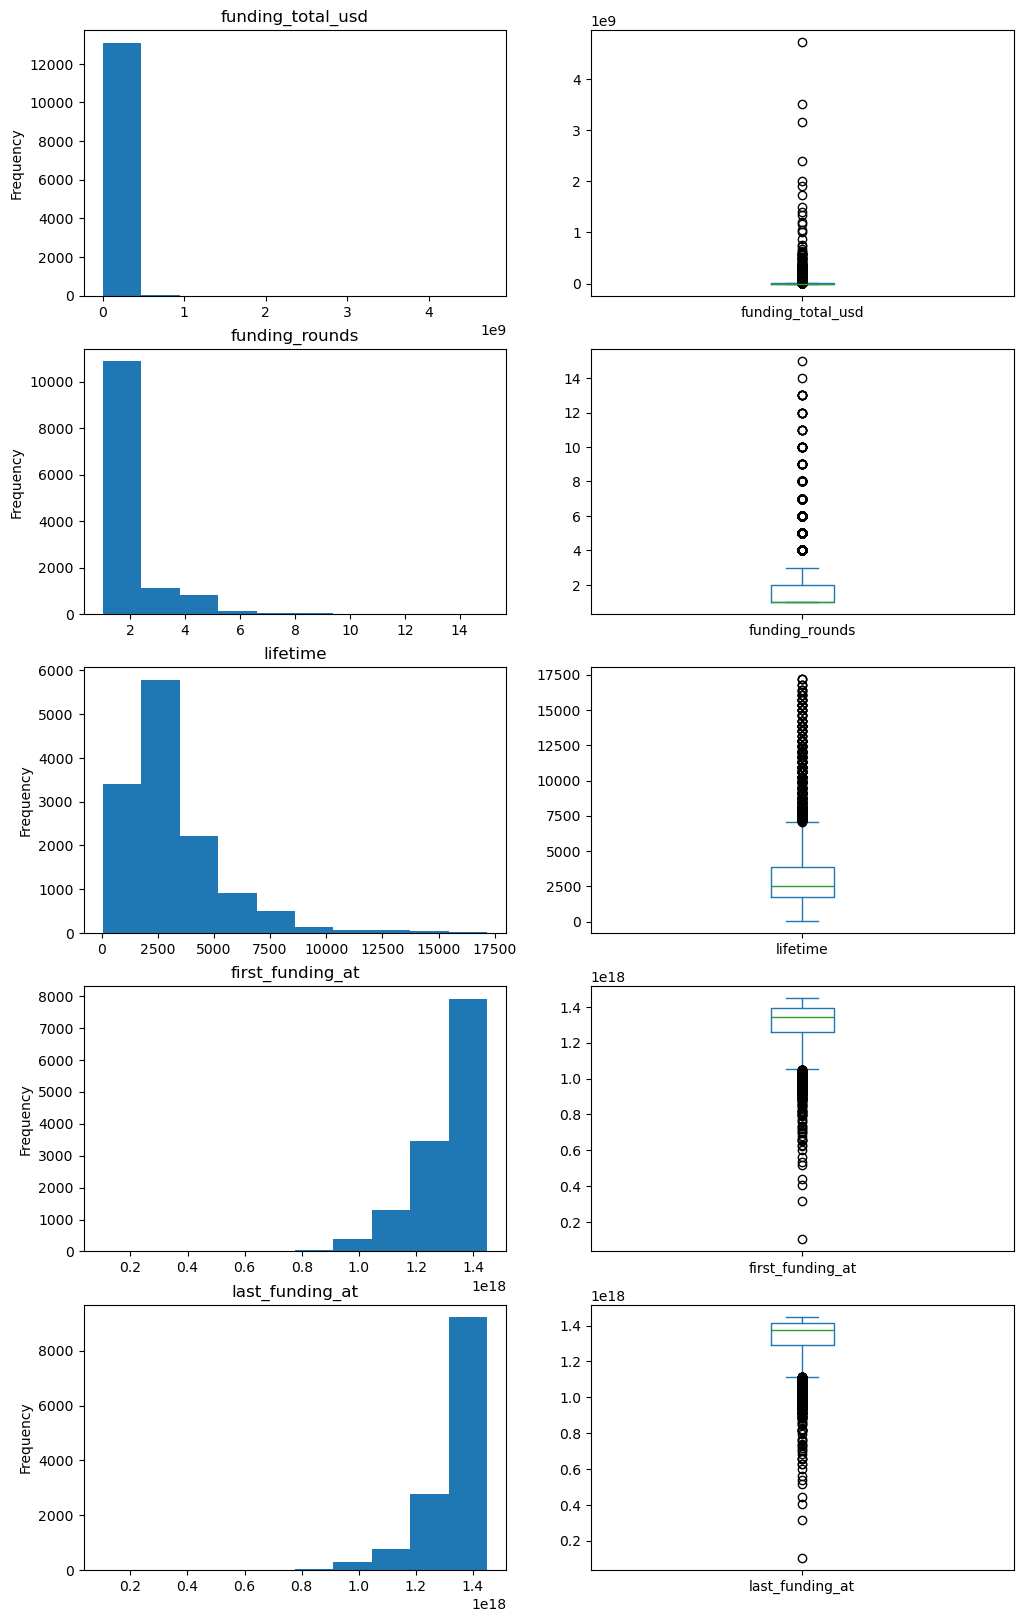

In [52]:
# test_features

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12,20))
ax = ax.flatten()
j = 0
for i in num_columns:
    test_features[i].plot(kind='hist', ax=ax[j], rot=0)
    ax[j].set_title(i);
    test_features[i].plot(kind='box', ax=ax[j+1], rot=0)
    j = j + 2

Та же ситуация: много значений за пределами "усов ящика" для всех указанных полей.

### Удалим выбросы

Сделаем это по общему правилу: считаем выбросами те, у которых значения по данному полю больше, чем Q3 + 2\*IQR, либо меньше, чем Q1 - 2\*IQR

In [53]:
train_df.describe().T

,count,mean,min,25%,50%,75%,max,std
funding_total_usd,52516.0,14748853.893632,0.0,40000.0,1000000.0,6788929.0,30079503000.0,168378343.179467
funding_rounds,52516.0,1.74067,1.0,1.0,1.0,2.0,19.0,1.374522
founded_at,52516,2008-11-04 09:44:16.196206848,1970-02-05 00:00:00,2006-10-01 00:00:00,2010-10-01 00:00:00,2013-01-01 00:00:00,2016-04-02 00:00:00,NaN
first_funding_at,52516.0,1310877933247010304.0,232502400000000000.0,1255305600000000000.0,1343001600000000000.0,1396310400000000000.0,1449273600000000000.0,114335253073815840.0
last_funding_at,52516.0,1340814582313961472.0,232502400000000000.0,1296518400000000000.0,1377820800000000000.0,1416182400000000000.0,1449446400000000000.0,105629989562130448.0
closed_at,52516,2017-06-11 05:36:46.504684032,1983-10-06 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,NaN
lifetime,52516.0,3140.828129,19.0,1739.0,2557.0,4018.0,17378.0,2147.82107


In [54]:
train_df = train_df.query('\
    funding_total_usd < 6788929 + 2*(6788929 - 40000) and \
    funding_rounds < 2 + 2*(2 - 1) and \
    lifetime < 4018 + 2*(4018 - 1739) and \
    first_funding_at > 1255305600000000000 - 2*(1396310400000000000 - 1255305600000000000) and \
    last_funding_at > 1296518400000000000 - 2*(1416182400000000000 - 1296518400000000000) \
')

## Категориальные признаки (включая дискретные)

Исследуем категориальные признаки для тренировочной и тестовой выборок, разместив их попарно

In [55]:
cat_columns = [
    'cat_big',
    'country_code',
    'state_code',
    'region',
    'city',
    'funding_rounds' # дискретный, поэтому записываем в категориальные
]

Как показала предварительная обработка данных, в категориальных признаках много уникальных значений, поэтому выведем только 7 наиболее часто встречающихся:

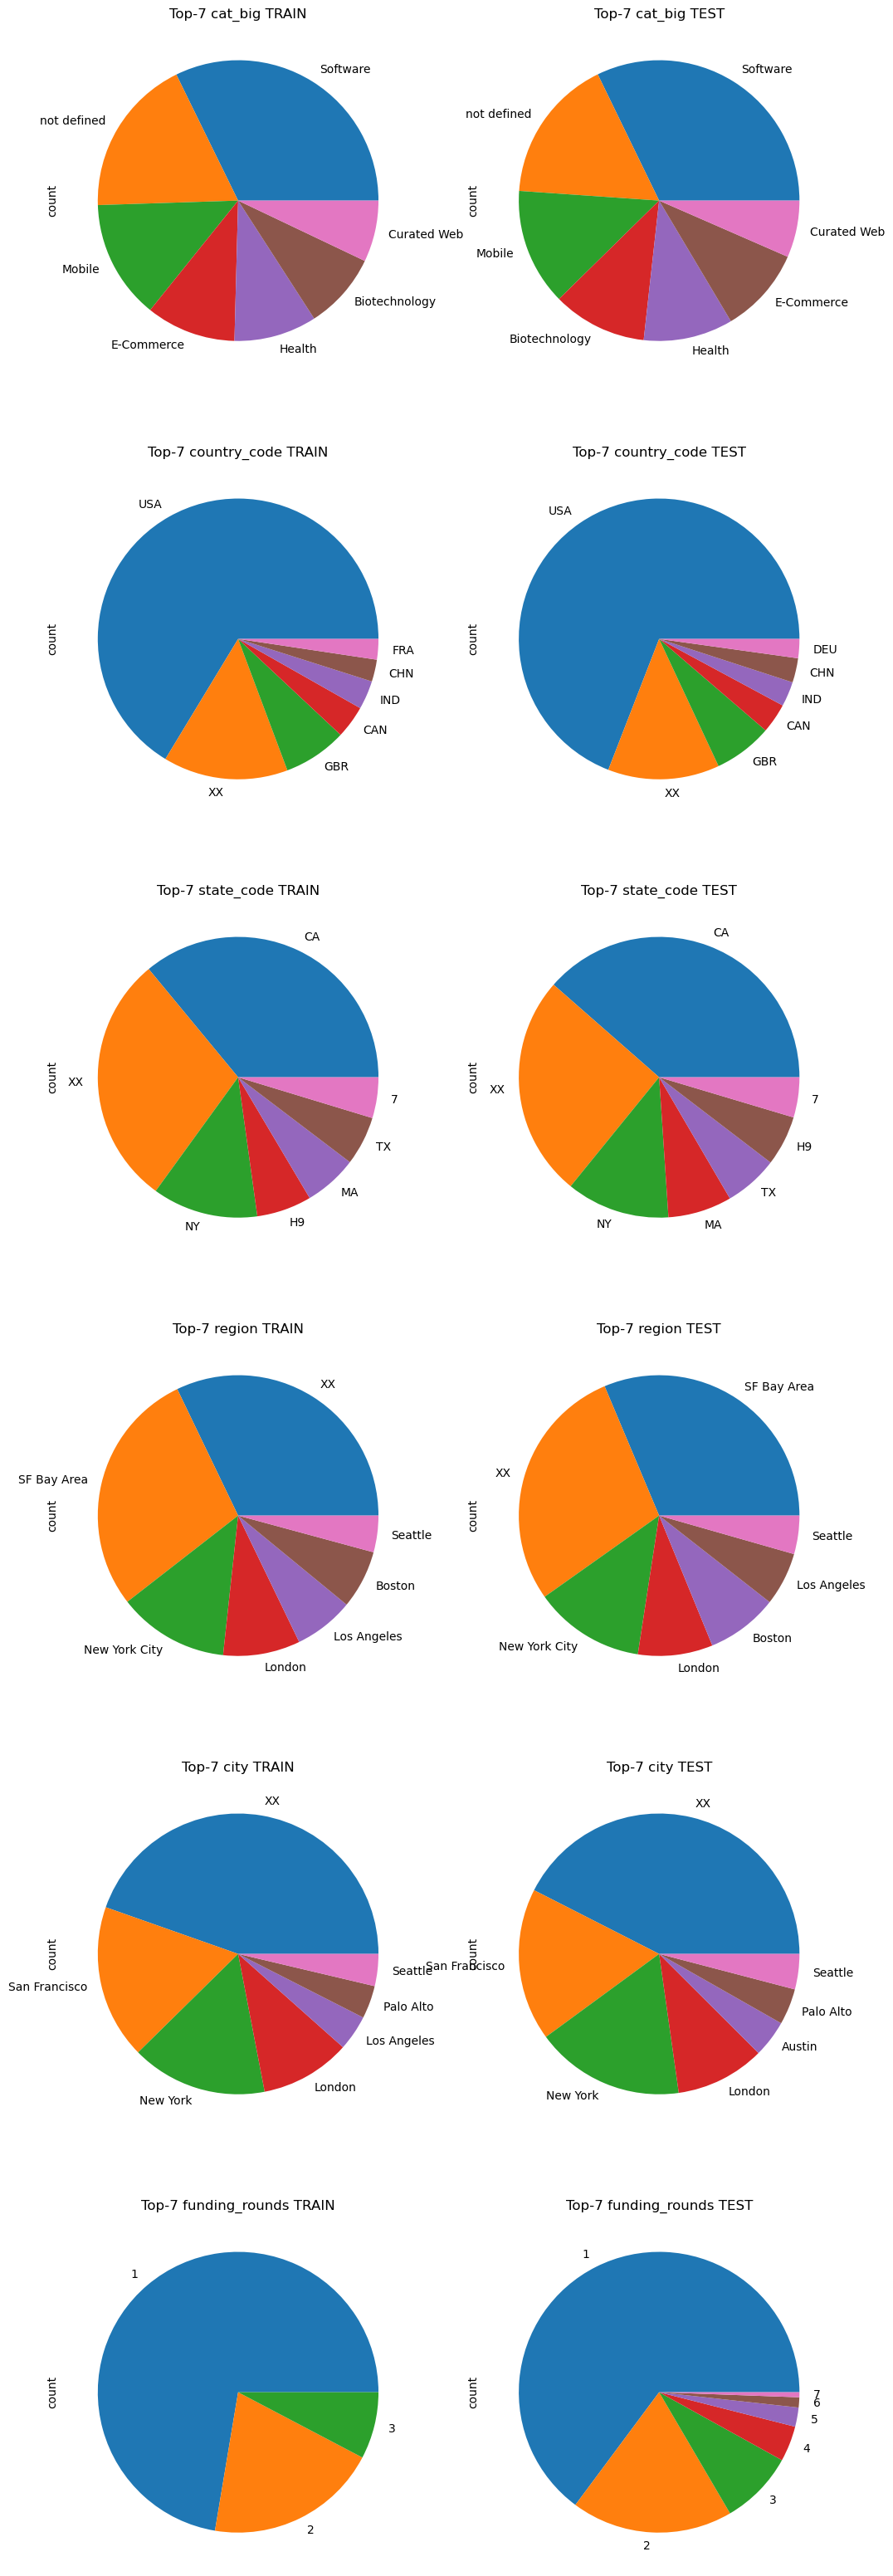

In [56]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12,40))
ax = ax.flatten()
j = 0
for i in cat_columns:
    train_df[i].value_counts()[:7].plot(kind='pie', ax=ax[j], rot=0)
    ax[j].set_title('Top-7 '+i+' TRAIN');
    test_features[i].value_counts()[:7].plot(kind='pie', ax=ax[j+1], rot=0)
    ax[j+1].set_title('Top-7 '+i+' TEST');
    j = j + 2

Также посмотрим на поле status тренировочной выборки: 

In [57]:
train_df['status'].value_counts()

status
operating    37664
closed        4082
Name: count, dtype: int64

## Корреляция признаков между собой

In [58]:
interval_columns = [
    'funding_total_usd',
    'lifetime',
    'first_funding_at',
    'last_funding_at'
]

Исключим из анализа признак city ввиду его высокой кардинальности (более 4 тыс. уникальных значений)

In [59]:
train_df['city'].nunique()

4111

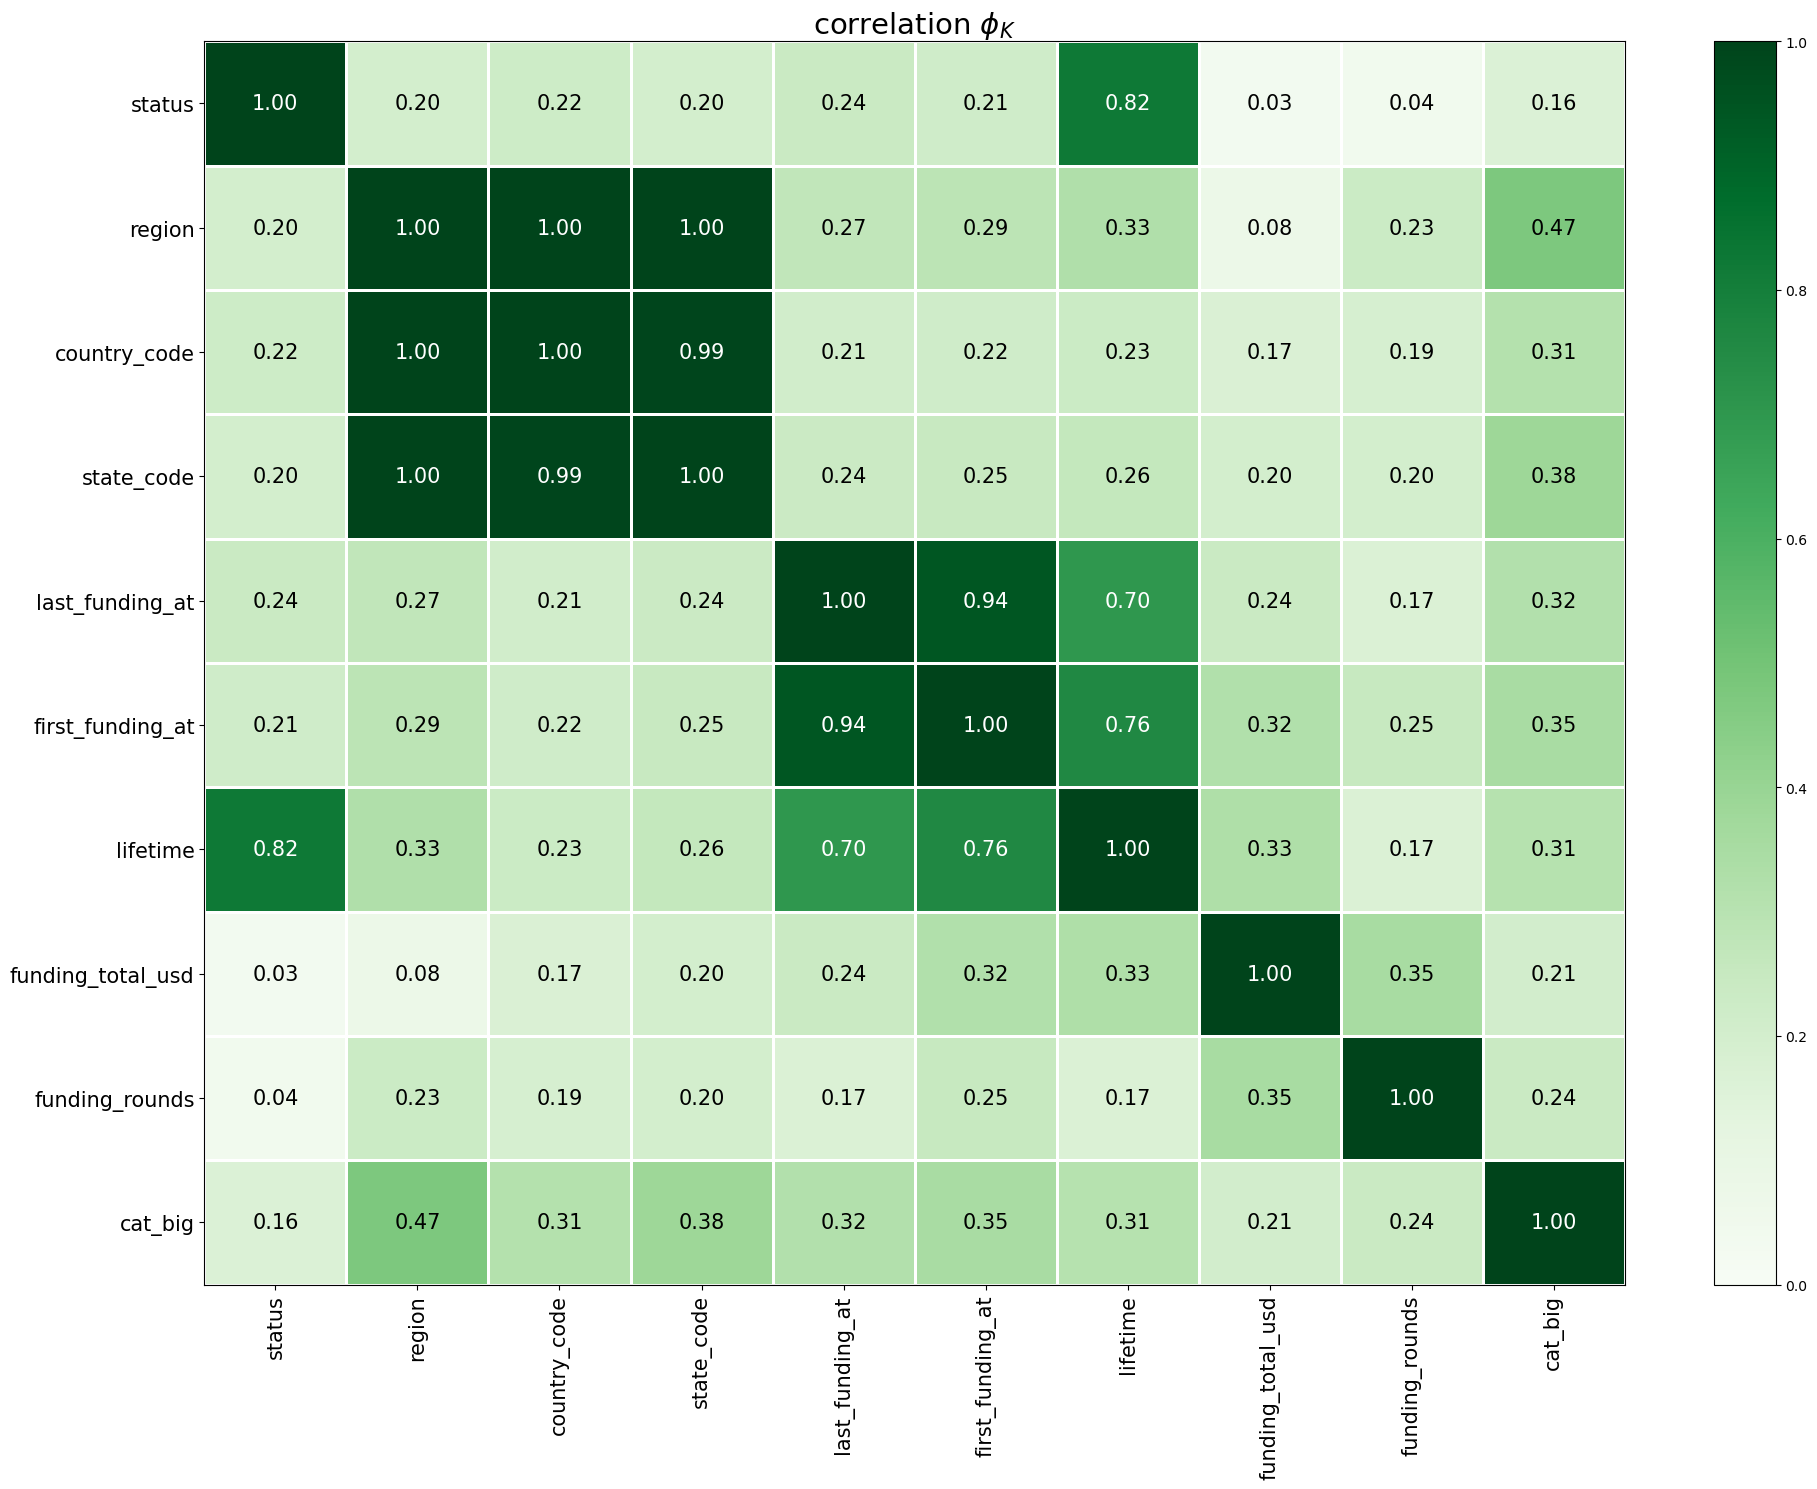

In [60]:
phik_overview = train_df[[
    'cat_big',
    'funding_rounds',
    'funding_total_usd',
    'lifetime',
    'first_funding_at',
    'last_funding_at',
    'state_code',
    'country_code',
    'region',
    'status'
]].phik_matrix(interval_cols=interval_columns)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Корреляция между country_code и city, region, state_code - высокая.

Выполним аналогичный корреляционный анализ для тестовой выборки. 
Поскольку разделение данных на выборки выполнено не нами, мы должны убедиться, что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на тестовой выборке, будет корректной

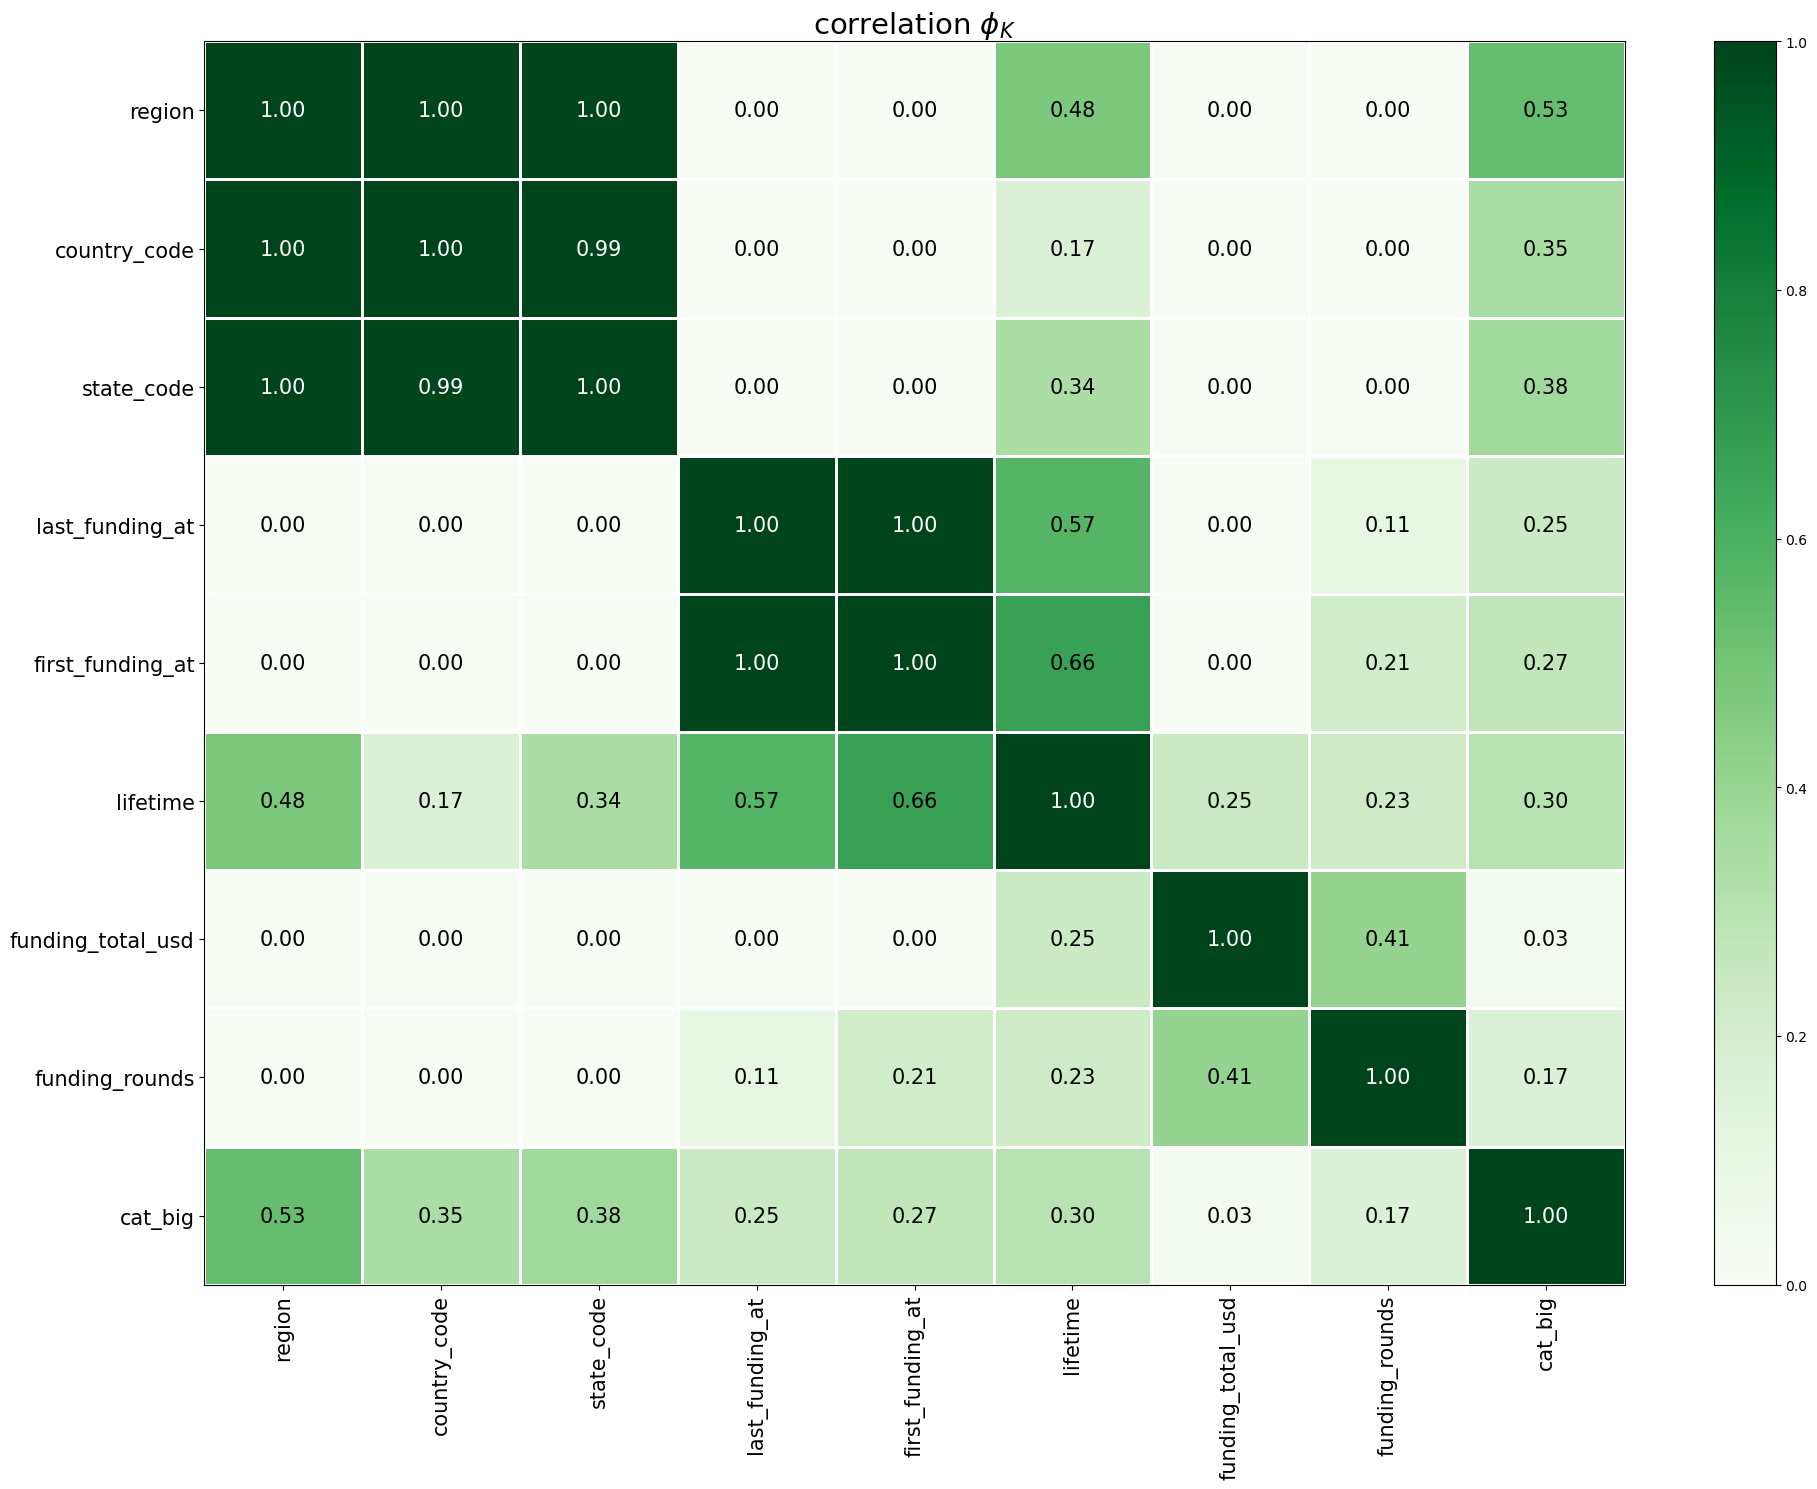

In [61]:
phik_overview = test_features[[
    'cat_big',
    'funding_rounds',
    'funding_total_usd',
    'lifetime',
    'first_funding_at',
    'last_funding_at',
    'state_code',
    'country_code',
    'region'
]].phik_matrix(interval_cols=interval_columns)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

В тренировочной и тестовой выборках имеются заметные различия в части распределений признаков, но в целом они не очень существенны.

Выводы: 

- имеются выбросы (аномальные значения) во всех числовых признаках.
- заметный дисбаланс имеется в признаках: country_code, state_code, категория (укрупоенное значение категории - cat_big);
- высокий дисбаланс целевого признака - учтем это при обучении модели;
- высокая коллинеарность между признаками - country_code, city, region, state_code. 


Признаки следует подготовить так:

1. Количественные: выполнить масштабирование.
2. Категориальные: заполним пропуски (уже сделано) и выполнить кодирование. 

# Подготовка данных

## Отделим целевой признак от входных

In [62]:
X_train = train_df[[
'funding_total_usd',
'state_code',
'funding_rounds',
'cat_big',
'lifetime',
'first_funding_at',
'last_funding_at',
'country_code',
'region',
'city' 
]]

In [63]:
y_train = train_df['status']

## Выполним кодирование целевого признака

In [64]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)

# Обучение модели

## Используем CatBoostClassifier

Учтем дисбаланс целевого признака

In [65]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [66]:
catboost_clf = CatBoostClassifier(
    class_weights = class_weights, 
    random_state = 42, 
    cat_features = ['cat_big', 'state_code', 'city', 'country_code', 'region'])

In [67]:
model = catboost_clf.fit(X_train, y_train, verbose=False)

# Получим прогноз на тестовых данных

In [68]:
X_test = test_features[[
'funding_total_usd',
'state_code',
'funding_rounds',
'cat_big',
'lifetime',
'first_funding_at',
'last_funding_at',
'country_code',
'region',
'city' 
]]

In [69]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   funding_total_usd  13125 non-null  int64 
 1   state_code         13125 non-null  object
 2   funding_rounds     13125 non-null  int64 
 3   cat_big            13125 non-null  object
 4   lifetime           13125 non-null  int64 
 5   first_funding_at   13125 non-null  int64 
 6   last_funding_at    13125 non-null  int64 
 7   country_code       13125 non-null  object
 8   region             13125 non-null  object
 9   city               13125 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.0+ MB


In [70]:
test_features['status'] = model.predict(X_test)

In [71]:
test_features['status'] = np.where(test_features['status'] == 1, 'operating', 'closed')

In [72]:
test_features[['name','status']].to_csv('M1_DS_Startups_v9.csv', index=False)

Метрика на kaggle (на 01.11.24 18:34) - 0.85759

https://www.kaggle.com/competitions/startups-operations-close-predictions-m-1-41-ds/leaderboard


# Оценим влияние входных признаков на целевой

Используем рассчитанные моделью коэффициенты:

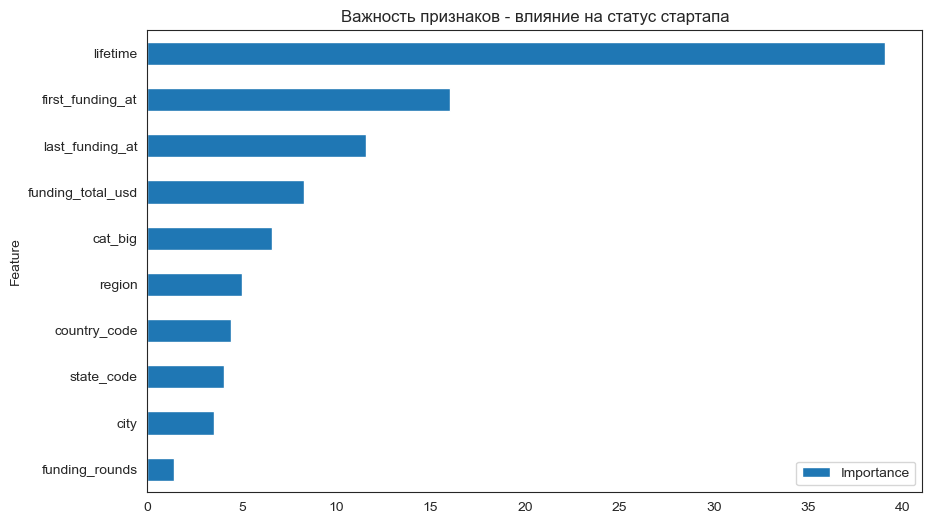

In [73]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) \
    .set_title("Важность признаков - влияние на статус стартапа");

Факторы, влияющие более всего на cтатус стартапа, следующие:
1. Время жизни стартапа (утечка, но тем не менее).
2. Дата начала финансирования.
3. Дата окончания финансирования.
4. Сумма финансирования.
5. Категория.

# Вывод

Проведено исследование данных о стартапах, функционировавших в период с 1970 по 2018 годы.

Решены задачи:

Построена модель, которая сможет предсказать статус стартапа.
С помощью построенной модели сделан прогноз состояния стартапов на тестовой выборке.

Этапы выполненной работы:

* Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов.    
* Предобработка данных: обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
* Исследовательский анализ данных.
* Подготовка данных.
* Обучение модели.
* Прогноз.


Факторы, влияющие более всего на cтатус стартапа, следующие:

1. Время жизни стартапа (утечка, но тем не менее).
2. Дата начала финансирования.
3. Дата окончания финансирования.
4. Сумма финансирования.
5. Категория.

Предложения для бизнеса, направленные на поддержание стартапа:

1. Своевременно выполнять финасирование стартапа.
2. Выполнять финасирование стартапа в течение достаточно длительного времени. 
3. Выполнять финансирование стартапа в достаточных объемах.
4. Разумно выбирать сферу деятельности.